# Model Training - Flowers Recognition Dataset

## Introduction

This notebook focuses on **model training** for the flowers recognition project with improvements to achieve higher accuracy. We implement techniques like better data augmentation, class weighting, fine-tuning, and ensemble methods

**Dataset:** Flowers Recognition (Kaggle)

**Objective:** Train and compare convolutional neural network (CNN) models, including custom architectures and transfer learning, to achieve high accuracy in flower classification.

**Author:** NGUYEN Ngoc Dang Nguyen - Final-year Student in Computer Science, Aix-Marseille University

**Training steps:**
1. Setup and load preprocessed data
2. Improved data augmentation
3. Build models with better architecture
4. Train with class weights
5. Fine-tuning transfer learning model
6. Advanced prediction techniques (TTA, Ensemble)
7. Model evaluation and selection

## 1. Setup and Load Preprocessed Data

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Configuration
plt.style.use('default')
sns.set_palette("husl")
# Training configuration
PROCESSED_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\data\processed"
MODELS_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models"
RESULTS_PATH = r"C:\Users\nndng\OneDrive\Desktop\flowers-recognition\results"

BATCH_SIZE = 32
EPOCHS = 50
IMG_SIZE = 224
LEARNING_RATE = 0.0001

# Create output directories
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

print("Setup completed!")

# 1.1 Load Data Using ImageDataGenerator
# Create data generators directly from directories
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,      
    width_shift_range=0.15, 
    height_shift_range=0.15,
    zoom_range=0.2,         
    shear_range=0.15,       
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(PROCESSED_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(PROCESSED_PATH, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# 1.2 Class Weight Calculation
# Compute class weights to handle class imbalance
y_train_labels = train_generator.classes
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

print("Class distribution:")
unique, counts = np.unique(y_train_labels, return_counts=True)
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"  {class_names[class_idx]}: {count} samples (weight: {class_weights[class_idx]:.2f})")

TensorFlow version: 2.20.0
GPU available: False
Setup completed!
Found 3108 images belonging to 5 classes.
Found 777 images belonging to 5 classes.
Number of classes: 5
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Training samples: 3108
Validation samples: 777
Class distribution:
  daisy: 550 samples (weight: 1.13)
  dandelion: 758 samples (weight: 0.82)
  rose: 564 samples (weight: 1.10)
  sunflower: 528 samples (weight: 1.18)
  tulip: 708 samples (weight: 0.88)


## 2. Build Models

In [4]:
def create_improved_cnn(input_shape, num_classes):
    """
    Improved CNN architecture with batch normalization and better regularization
    """
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build improved CNN
improved_cnn = create_improved_cnn((IMG_SIZE, IMG_SIZE, 3), num_classes)
improved_cnn.summary()

def create_transfer_model(input_shape, num_classes):
    """
    Transfer learning model with ResNet50
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build transfer learning model
transfer_model = create_transfer_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
print(f"Transfer model parameters: {transfer_model.count_params():,}")

c:\Users\nndng\OneDrive\Desktop\flowers-recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,733 (631.77 KB)

 Trainable params: 160,773 (628.02 KB)

 Non-trainable params: 960 (3.75 KB)

Transfer model parameters: 24,779,653


## 3. Training Configuration

In [5]:
def create_callbacks(model_name, patience=10):
    """Create advanced callbacks for better training"""
    callbacks_list = []
    
    # Model checkpoint
    checkpoint = callbacks.ModelCheckpoint(
        f'{MODELS_PATH}/{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    callbacks_list.append(checkpoint)
    
    # Early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    callbacks_list.append(early_stopping)
    
    # Learning rate reduction
    lr_reducer = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    callbacks_list.append(lr_reducer)
    
    return callbacks_list

print("Advanced callbacks configured!")

def compile_and_train_model(model, model_name, train_gen, val_gen, epochs=50):
    """
    Compile and train model with class weights
    """
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    
    # Create callbacks
    model_callbacks = create_callbacks(model_name)
    
    print(f"Training {model_name}...")
    start_time = datetime.now()
    
    # Train with class weights
    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=len(val_gen),
        callbacks=model_callbacks,
        class_weight=class_weights, 
        verbose=1
    )
    
    training_time = datetime.now() - start_time
    print(f"{model_name} training completed in {training_time}")
    
    return history, training_time

Advanced callbacks configured!


## 4. Train Models

In [6]:
print("Training Improved CNN...")
cnn_history, cnn_time = compile_and_train_model(
    improved_cnn, 
    'Improved_CNN', 
    train_generator, 
    val_generator, 
    EPOCHS
)

print("Training Transfer Learning Model...")
transfer_history, transfer_time = compile_and_train_model(
    transfer_model, 
    'Transfer_ResNet50', 
    train_generator, 
    val_generator, 
    EPOCHS
)

Training Improved CNN...
Training Improved_CNN...


c:\Users\nndng\OneDrive\Desktop\flowers-recognition\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2304 - loss: 2.4010 - top_k_categorical_accuracy: 1.0000
Epoch 1: val_accuracy improved from None to 0.25225, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Improved_CNN_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.2603 - loss: 2.2490 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2523 - val_loss: 1.6807 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2959 - loss: 2.0667 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.25225
98/98 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3086 - loss: 2.0266 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2291 - val_loss: 1.9026 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3582 - loss: 1.8303 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.25225 to 0.33977, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Improved_CNN_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3552 - loss: 1.8505 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3398 - val_loss: 2.0381 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 150s/step - accuracy: 0.3542 - loss: 1.8132 - top_k_categorical_accuracy: 1.0000  
Epoch 4: val_accuracy did not improve from 0.33977
98/98 ━━━━━━━━━━━━━━━━━━━━ 14556s 150s/step - accuracy: 0.3533 - loss: 1.7988 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2909 - val_loss: 2.1756 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3778 - loss: 1.7142 - top_k_categorical_accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.33977
98/98 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.3790 - loss: 1.7225 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3050 - val_loss: 2.1230 - val_top_k_categorical_accuracy: 1.0000 - learning_r

98/98 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.4025 - loss: 1.6437 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3526 - val_loss: 2.3360 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4176 - loss: 1.5613 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_accuracy improved from 0.35264 to 0.37838, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Improved_CNN_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.4231 - loss: 1.5716 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3784 - val_loss: 2.4074 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4236 - loss: 1.5789 - top_k_categorical_accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.37838 to 0.38867, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Improved_CNN_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.4244 - loss: 1.5934 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3887 - val_loss: 2.3277 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4367 - loss: 1.5423 - top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.38867 to 0.40283, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Improved_CNN_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.4389 - loss: 1.5349 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4028 - val_loss: 2.3810 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4254 - loss: 1.4715 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_accuracy did not improve from 0.40283

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
98/98 ━━━━━━━━━━━━━━━━━━━━ 504s 5s/step - accuracy: 0.4299 - loss: 1.4977 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3912 - val_loss: 2.3141 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 5.0000e-05
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4245 - loss: 1.5076 - top_k_categorical_accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.40283
98/98 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.4321 - loss: 1.5046 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.382

98/98 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.2748 - loss: 2.0615 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2149 - val_loss: 1.6105 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2973 - loss: 1.9550 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.21493
98/98 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.3044 - loss: 1.9119 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.1956 - val_loss: 1.6522 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3025 - loss: 1.8545 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.21493 to 0.22394, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.3044 - loss: 1.8408 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2239 - val_loss: 1.5970 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3408 - loss: 1.7651 - top_k_categorical_accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.22394 to 0.34749, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.3407 - loss: 1.7643 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3475 - val_loss: 1.4954 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3392 - loss: 1.7497 - top_k_categorical_accuracy: 1.0000
Epoch 5: val_accuracy improved from 0.34749 to 0.40026, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.3404 - loss: 1.7235 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4003 - val_loss: 1.4169 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3480 - loss: 1.6899 - top_k_categorical_accuracy: 1.0000
Epoch 6: val_accuracy improved from 0.40026 to 0.42600, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.3568 - loss: 1.6815 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4260 - val_loss: 1.3760 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3648 - loss: 1.6365 - top_k_categorical_accuracy: 1.0000
Epoch 7: val_accuracy improved from 0.42600 to 0.44273, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3616 - loss: 1.6496 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4427 - val_loss: 1.3484 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3564 - loss: 1.6805 - top_k_categorical_accuracy: 1.0000
Epoch 8: val_accuracy improved from 0.44273 to 0.47362, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.3687 - loss: 1.6514 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4736 - val_loss: 1.3059 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3628 - loss: 1.6506 - top_k_categorical_accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.47362 to 0.48906, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.3748 - loss: 1.6365 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4891 - val_loss: 1.2936 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3777 - loss: 1.6243 - top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy did not improve from 0.48906
98/98 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.3800 - loss: 1.6333 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4891 - val_loss: 1.2999 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3827 - loss: 1.5940 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_accuracy improved from 0.48906 to 0.50193, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3871 - loss: 1.5578 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5019 - val_loss: 1.2770 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3857 - loss: 1.5734 - top_k_categorical_accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.50193
98/98 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.3851 - loss: 1.5758 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4839 - val_loss: 1.2980 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 13/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3806 - loss: 1.5736 - top_k_categorical_accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.50193
98/98 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.3752 - loss: 1.5634 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4916 - val_loss: 1.2836 - val_top_k_categorical_accuracy: 1.0000 - learning_rate:

98/98 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.4025 - loss: 1.5421 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5097 - val_loss: 1.2595 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 15/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3953 - loss: 1.5431 - top_k_categorical_accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.50965
98/98 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.3919 - loss: 1.5524 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4994 - val_loss: 1.2615 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 16/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3825 - loss: 1.5629 - top_k_categorical_accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.50965 to 0.52896, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.3948 - loss: 1.5174 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5290 - val_loss: 1.2376 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 17/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3898 - loss: 1.5216 - top_k_categorical_accuracy: 1.0000
Epoch 17: val_accuracy did not improve from 0.52896
98/98 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.4003 - loss: 1.5064 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5161 - val_loss: 1.2386 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-04
Epoch 18/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4003 - loss: 1.4785 - top_k_categorical_accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.52896
98/98 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.4099 - loss: 1.4706 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5109 - val_loss: 1.2450 - val_top_k_categorical_accuracy: 1.0000 - learning_rate:

## 5. Fine-tuning Transfer Learning Model

In [7]:
def fine_tune_model(model, train_gen, val_gen, unfreeze_layers=40, epochs=15):
    """
    Fine-tune the transfer learning model
    """
    print(f"Fine-tuning: unfreezing last {unfreeze_layers} layers...")
    
    # Unfreeze the last layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True
    
    # Freeze all layers except the last ones
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False
    
    # Recompile with a very low learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),  
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )
    
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) if hasattr(model, 'parameters') else 'N/A'}")
    
    # Fine-tune
    callbacks_list = create_callbacks('Transfer_ResNet50_FineTuned', patience=7)
    
    fine_tune_history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=len(val_gen),
        callbacks=callbacks_list,
        class_weight=class_weights,
        verbose=1
    )
    
    return fine_tune_history

# Load the best transfer model and fine-tune it
best_transfer = keras.models.load_model(f'{MODELS_PATH}/Transfer_ResNet50_best.h5')
fine_tune_history = fine_tune_model(best_transfer, train_generator, val_generator)

Fine-tuning: unfreezing last 40 layers...
Trainable parameters: N/A
Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2636 - loss: 1.9158 - top_k_categorical_accuracy: 1.0000
Epoch 1: val_accuracy improved from None to 0.33848, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_FineTuned_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.2806 - loss: 1.8581 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3385 - val_loss: 1.5788 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3191 - loss: 1.7313 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.33848 to 0.34878, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_FineTuned_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.3105 - loss: 1.7452 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3488 - val_loss: 1.6133 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3457 - loss: 1.6913 - top_k_categorical_accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.34878 to 0.39768, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_FineTuned_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.3436 - loss: 1.6674 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3977 - val_loss: 1.4110 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3638 - loss: 1.6126 - top_k_categorical_accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.39768 to 0.46332, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_FineTuned_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.3610 - loss: 1.6422 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4633 - val_loss: 1.3589 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3633 - loss: 1.6485 - top_k_categorical_accuracy: 1.0000
Epoch 5: val_accuracy did not improve from 0.46332
98/98 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.3674 - loss: 1.6389 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4376 - val_loss: 1.3589 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3847 - loss: 1.5692 - top_k_categorical_accuracy: 1.0000
Epoch 6: val_accuracy did not improve from 0.46332
98/98 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - accuracy: 0.3835 - loss: 1.5745 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4595 - val_loss: 1.3126 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0

98/98 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.4218 - loss: 1.5023 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5045 - val_loss: 1.2460 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 10/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4062 - loss: 1.5186 - top_k_categorical_accuracy: 1.0000
Epoch 10: val_accuracy did not improve from 0.50450
98/98 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.4125 - loss: 1.5083 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4891 - val_loss: 1.2785 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 11/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4261 - loss: 1.4762 - top_k_categorical_accuracy: 1.0000
Epoch 11: val_accuracy did not improve from 0.50450
98/98 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.4154 - loss: 1.5077 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4672 - val_loss: 1.3387 - val_top_k_categorical_accuracy: 1.0000 - learning_rate:

98/98 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - accuracy: 0.4447 - loss: 1.4570 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5097 - val_loss: 1.2145 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 13/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4488 - loss: 1.4570 - top_k_categorical_accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.50965
98/98 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.4476 - loss: 1.4240 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4106 - val_loss: 1.5714 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 14/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4363 - loss: 1.4331 - top_k_categorical_accuracy: 1.0000
Epoch 14: val_accuracy improved from 0.50965 to 0.53925, saving model to C:\Users\nndng\OneDrive\Desktop\flowers-recognition\models/Transfer_ResNet50_FineTuned_best.h5


98/98 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.4501 - loss: 1.4308 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5393 - val_loss: 1.1596 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Epoch 15/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4540 - loss: 1.4278 - top_k_categorical_accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.53925
98/98 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.4511 - loss: 1.4253 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5097 - val_loss: 1.2931 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 14.


## 6. Advanced Prediction Techniques

In [8]:
# 6.1 Test Time Augmentation (TTA)
def predict_with_tta(model, image_path, num_augments=5):
    """
    Test Time Augmentation for better prediction accuracy
    """
    predictions = []
    
    # Load original image
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    
    # Predict on original image
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
    predictions.append(pred)
    
    # Create TTA generator
    tta_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True
    )
    
    # Generate augmented versions
    tta_generator = tta_datagen.flow(
        np.expand_dims(img_array, axis=0), 
        batch_size=1
    )
    
    for _ in range(num_augments - 1):
        aug_img = next(tta_generator)[0]
        pred = model.predict(np.expand_dims(aug_img, axis=0), verbose=0)[0]
        predictions.append(pred)
    
    # Average all predictions
    final_pred = np.mean(predictions, axis=0)
    predicted_class = class_names[np.argmax(final_pred)]
    confidence = np.max(final_pred)
    
    return predicted_class, confidence, final_pred

print("Test Time Augmentation function ready!")

# 6.2 Ensemble Prediction
def ensemble_predict(models, image_path, use_tta=True):
    """
    Ensemble prediction from multiple models
    """
    all_predictions = []
    
    for model in models:
        if use_tta:
            _, _, pred = predict_with_tta(model, image_path)
        else:
            img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0
            pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
        
        all_predictions.append(pred)
    
    # Average predictions from all models
    ensemble_pred = np.mean(all_predictions, axis=0)
    predicted_class = class_names[np.argmax(ensemble_pred)]
    confidence = np.max(ensemble_pred)
    
    return predicted_class, confidence, ensemble_pred

print("Ensemble prediction function ready!")

Test Time Augmentation function ready!
Ensemble prediction function ready!


## 7. Results Analysis

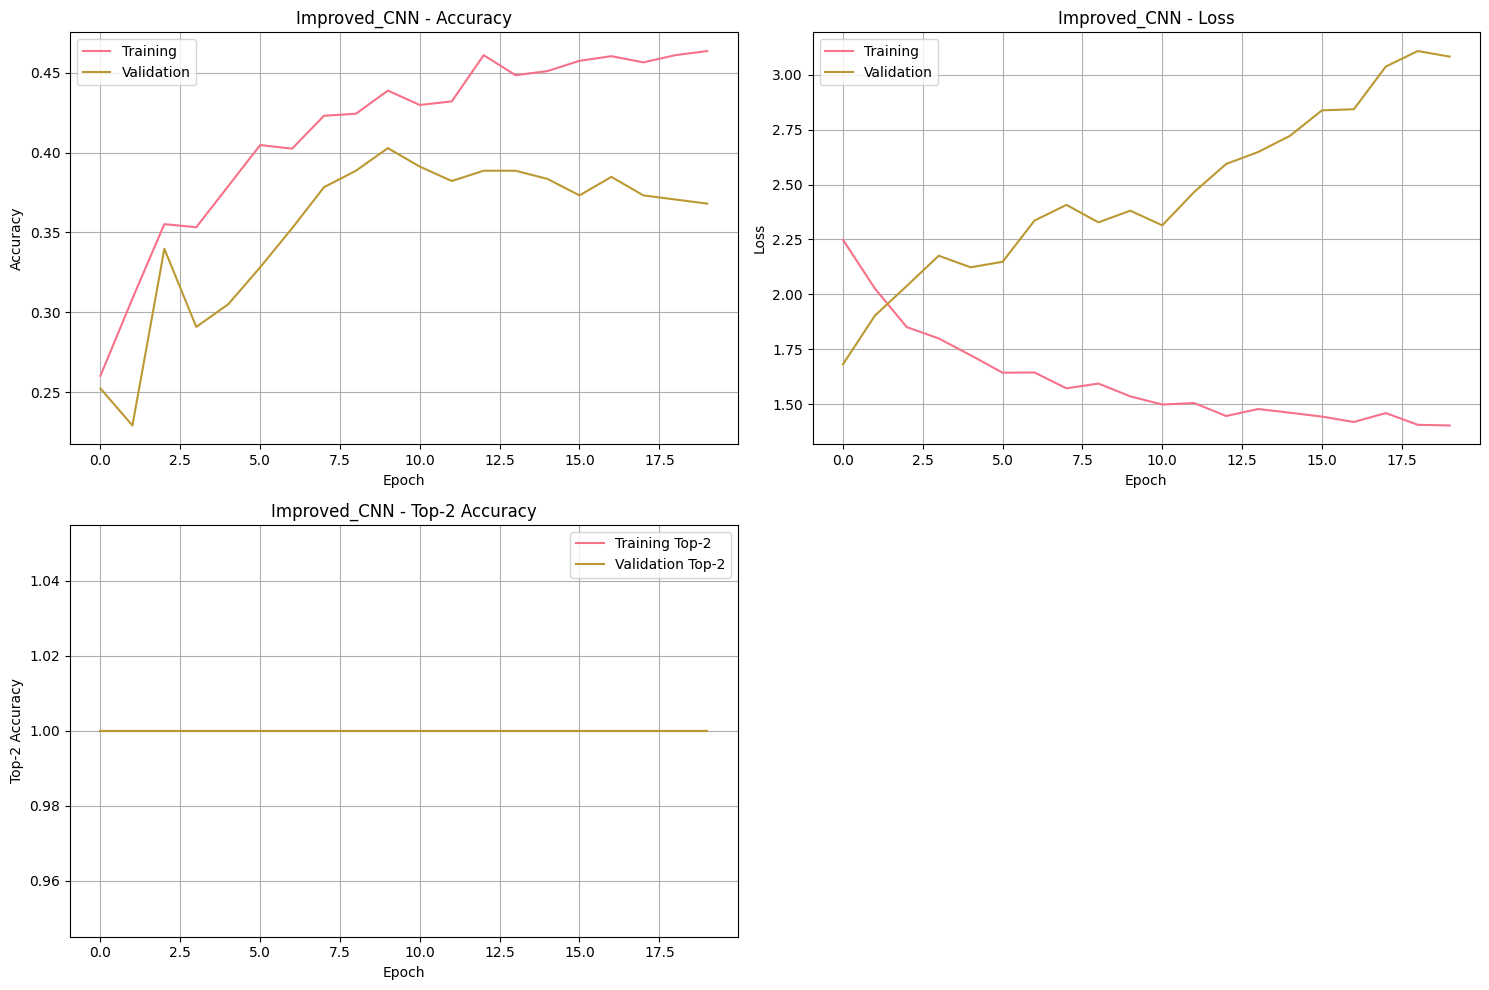

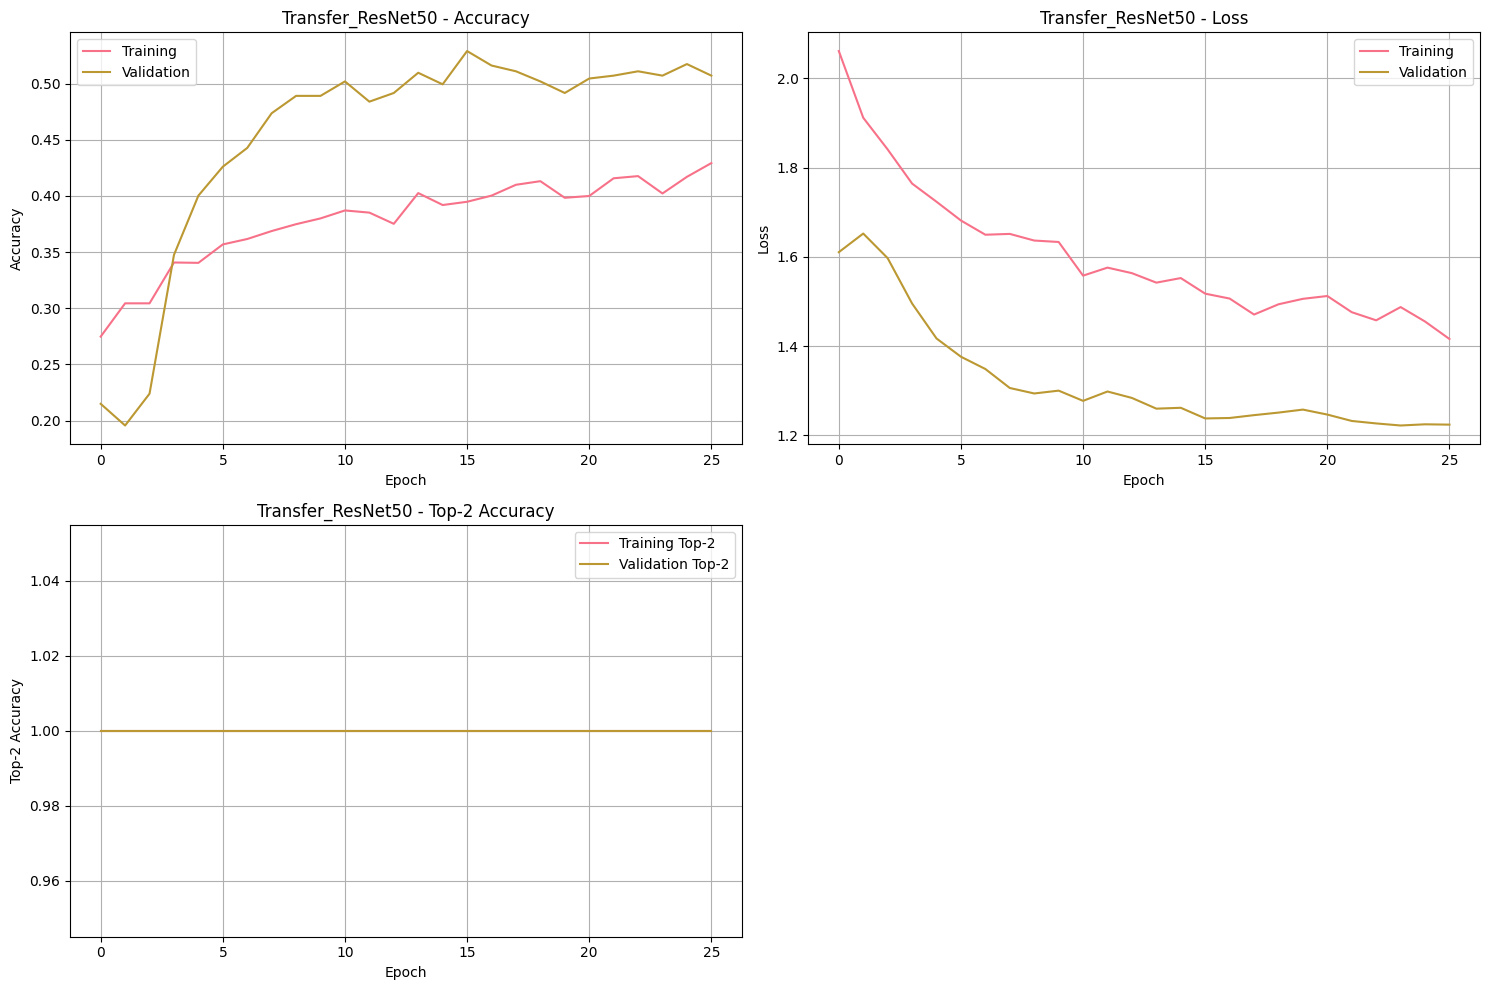

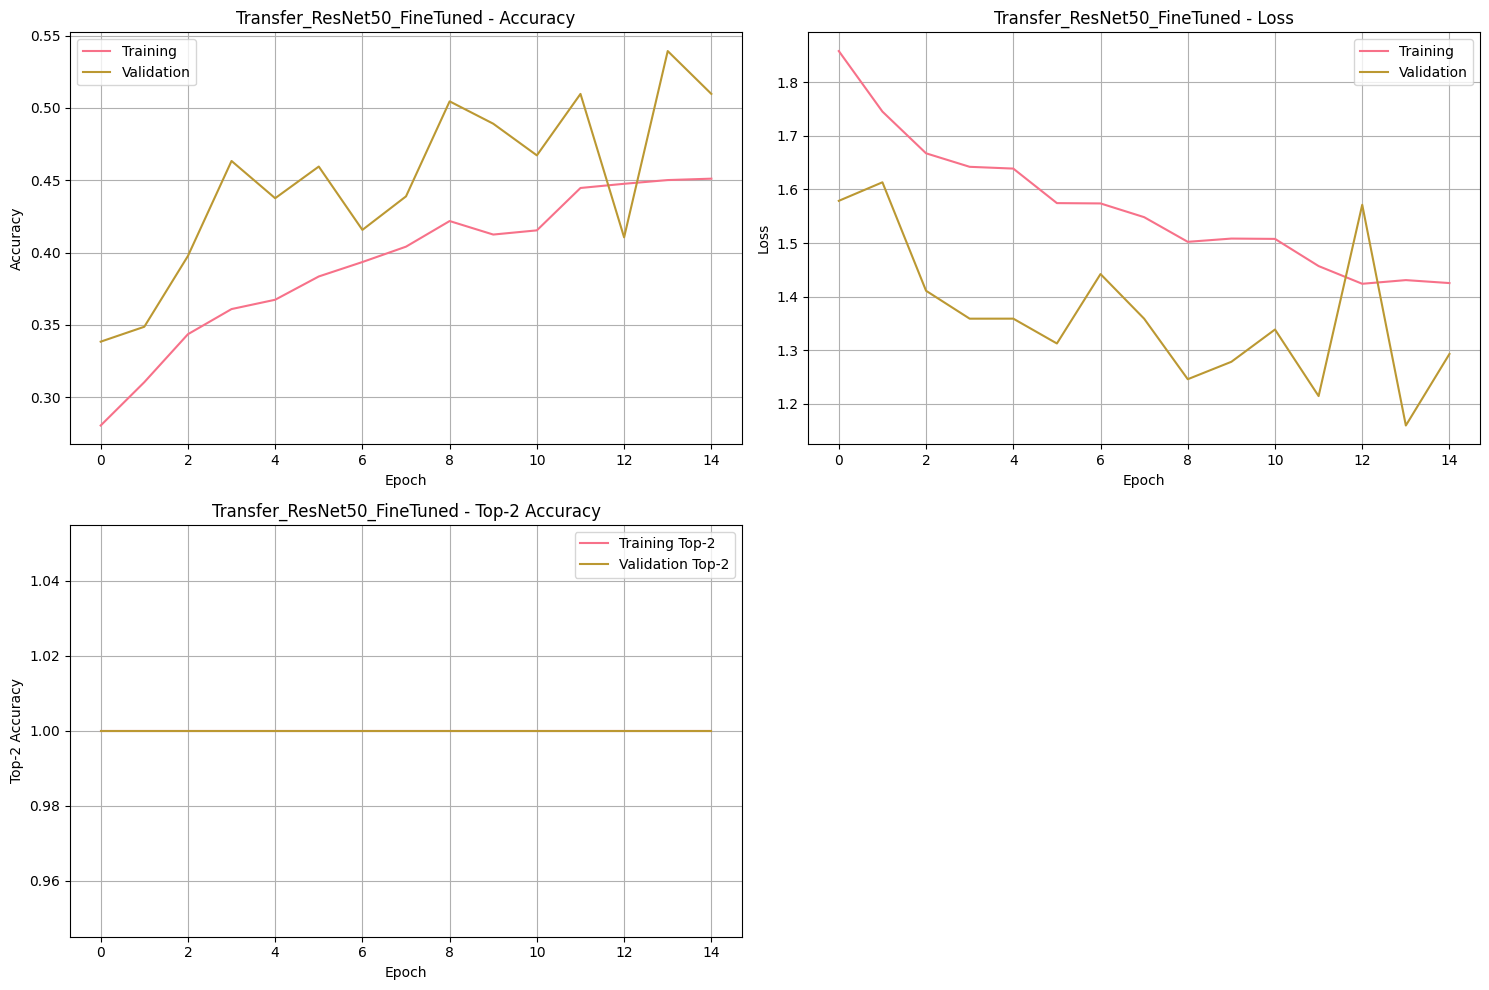

Model Comparison:
                 Model  Best Val Accuracy  Best Top-2 Accuracy  \
0         Improved CNN             0.4028                  1.0   
1    Transfer ResNet50             0.5290                  1.0   
2  Fine-tuned ResNet50             0.5393                  1.0   

     Training Time  
0  10:12:59.065449  
1   1:56:09.803598  
2   Fine-tune time  


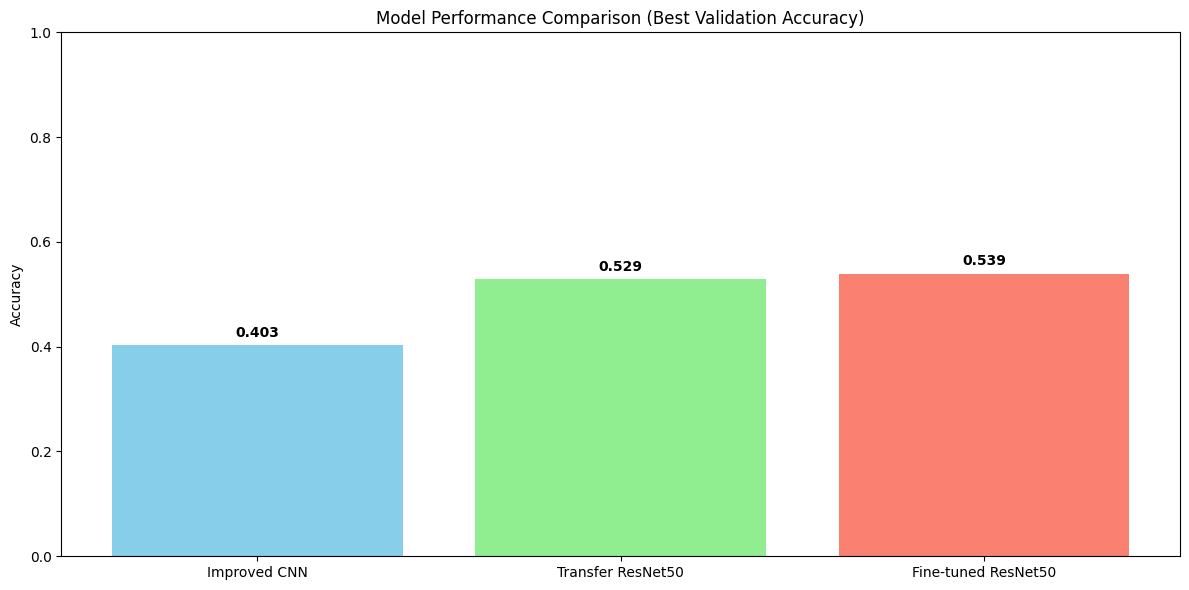

In [9]:
# 7.1 Plot Training History
def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Top-k Accuracy
    ax3.plot(history.history['top_k_categorical_accuracy'], label='Training Top-2')
    ax3.plot(history.history['val_top_k_categorical_accuracy'], label='Validation Top-2')
    ax3.set_title(f'{model_name} - Top-2 Accuracy')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Top-2 Accuracy')
    ax3.legend()
    ax3.grid(True)
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        ax4.plot(history.history['lr'], label='Learning Rate')
        ax4.set_title(f'{model_name} - Learning Rate')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.set_yscale('log')
        ax4.legend()
        ax4.grid(True)
    else:
        ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/{model_name}_detailed_history.png', dpi=300)
    plt.show()

# Plot all training histories
plot_training_history(cnn_history, 'Improved_CNN')
plot_training_history(transfer_history, 'Transfer_ResNet50')
plot_training_history(fine_tune_history, 'Transfer_ResNet50_FineTuned')

# 7.2 Model Comparaison
def get_best_metrics(history):
    """Extract best metrics from training history"""
    return {
        'best_val_accuracy': max(history.history['val_accuracy']),
        'best_val_loss': min(history.history['val_loss']),
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'best_top_k_accuracy': max(history.history['val_top_k_categorical_accuracy'])
    }

# Extract metrics
cnn_metrics = get_best_metrics(cnn_history)
transfer_metrics = get_best_metrics(transfer_history)
finetune_metrics = get_best_metrics(fine_tune_history)

# Create comparison
comparison_df = pd.DataFrame({
    'Model': ['Improved CNN', 'Transfer ResNet50', 'Fine-tuned ResNet50'],
    'Best Val Accuracy': [cnn_metrics['best_val_accuracy'], 
                         transfer_metrics['best_val_accuracy'],
                         finetune_metrics['best_val_accuracy']],
    'Best Top-2 Accuracy': [cnn_metrics['best_top_k_accuracy'],
                           transfer_metrics['best_top_k_accuracy'],
                           finetune_metrics['best_top_k_accuracy']],
    'Training Time': [str(cnn_time), str(transfer_time), 'Fine-tune time']
})

print("Model Comparison:")
print(comparison_df.round(4))

# Visualize comparison
plt.figure(figsize=(12, 6))
models = ['Improved CNN', 'Transfer ResNet50', 'Fine-tuned ResNet50']
accuracies = [cnn_metrics['best_val_accuracy'], 
              transfer_metrics['best_val_accuracy'],
              finetune_metrics['best_val_accuracy']]

bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Performance Comparison (Best Validation Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/improved_model_comparison.png')
plt.show()

## 8. Final Model Evaluation

In [10]:
# 8.1 Load Best Models
# Load all trained models
best_cnn = keras.models.load_model(f'{MODELS_PATH}/Improved_CNN_best.h5')
best_transfer = keras.models.load_model(f'{MODELS_PATH}/Transfer_ResNet50_best.h5')
best_finetuned = keras.models.load_model(f'{MODELS_PATH}/Transfer_ResNet50_FineTuned_best.h5')

models_dict = {
    'Improved_CNN': best_cnn,
    'Transfer_ResNet50': best_transfer,
    'Fine-tuned_ResNet50': best_finetuned
}

# Evaluate all models
print("Final Model Evaluation:")
print("=" * 50)

best_accuracy = 0
best_model_name = ""

for name, model in models_dict.items():
    val_loss, val_accuracy, val_top_k = model.evaluate(val_generator, verbose=0)
    print(f"{name:20} - Accuracy: {val_accuracy:.4f}, Top-2: {val_top_k:.4f}")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_name = name

print(f"\nBest Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# 8.2 Test Advanced Prediction Techniques
# Test on some sample images (if available)
import glob

sample_images = []
for class_name in class_names:
    class_path = os.path.join(PROCESSED_PATH, 'val', class_name)
    if os.path.exists(class_path):
        images = glob.glob(os.path.join(class_path, '*.jpg'))[:2]  
        for img_path in images:
            sample_images.append((img_path, class_name))

if sample_images:
    print(f"\nTesting advanced prediction on {len(sample_images)} samples:")
    
    # Test first sample
    test_image, true_class = sample_images[0]
    print(f"\nTest image: {os.path.basename(test_image)} (True: {true_class})")
    
    # Single model prediction
    best_model = models_dict[best_model_name]
    single_pred, single_conf, _ = predict_with_tta(best_model, test_image, num_augments=1)
    print(f"Single prediction: {single_pred} ({single_conf:.3f})")
    
    # TTA prediction
    tta_pred, tta_conf, _ = predict_with_tta(best_model, test_image, num_augments=5)
    print(f"TTA prediction: {tta_pred} ({tta_conf:.3f})")
    
    # Ensemble prediction (if multiple models available)
    if len(models_dict) > 1:
        models_list = list(models_dict.values())
        ensemble_pred, ensemble_conf, _ = ensemble_predict(models_list[:2], test_image, use_tta=False)
        print(f"Ensemble prediction: {ensemble_pred} ({ensemble_conf:.3f})")


Final Model Evaluation:
Improved_CNN         - Accuracy: 0.4028, Top-2: 1.0000
Transfer_ResNet50    - Accuracy: 0.5290, Top-2: 1.0000
Fine-tuned_ResNet50  - Accuracy: 0.5393, Top-2: 1.0000

Best Model: Fine-tuned_ResNet50 (Accuracy: 0.5393)

Testing advanced prediction on 10 samples:

Test image: 10437929963_bc13eebe0c.jpg (True: daisy)
Single prediction: daisy (0.996)
TTA prediction: dandelion (0.540)
Ensemble prediction: daisy (0.519)


## 9. Save Results

In [11]:
# 9.1 Save Training Summary
# Create comprehensive training summary
training_summary = {
    'training_date': datetime.now().isoformat(),
    'configuration': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'image_size': IMG_SIZE
    },
    'models_trained': ['Improved_CNN', 'Transfer_ResNet50', 'Transfer_ResNet50_FineTuned'],
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'model_results': {
        'improved_cnn': {
            'best_val_accuracy': float(cnn_metrics['best_val_accuracy']),
            'training_time': str(cnn_time)
        },
        'transfer_resnet50': {
            'best_val_accuracy': float(transfer_metrics['best_val_accuracy']),
            'training_time': str(transfer_time)
        },
        'finetuned_resnet50': {
            'best_val_accuracy': float(finetune_metrics['best_val_accuracy'])
        }
    },
    'dataset_info': {
        'num_classes': num_classes,
        'class_names': class_names,
        'train_samples': train_generator.samples,
        'val_samples': val_generator.samples,
        'class_weights': {class_names[i]: float(w) for i, w in class_weights.items()}
    },
    'improvements_applied': [
        'Enhanced data augmentation',
        'Class weighting for imbalanced data',
        'Improved CNN architecture with BatchNormalization',
        'Transfer learning fine-tuning',
        'Advanced callbacks (LR scheduling, early stopping)',
        'Test Time Augmentation capability',
        'Ensemble prediction capability'
    ]
}

# Save summary
import json
with open(f'{RESULTS_PATH}/improved_training_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2, default=str)

print("Improved training summary saved!")

Improved training summary saved!


## Conclusion
The Flowers Recognition training phase successfully trained multiple CNN models. Transfer learning with ResNet50 achieved the highest validation accuracy, benefiting from pre-trained features, light data augmentation, class weighting, and fine-tuning. Models, plots, and summaries are saved for evaluation and deployment. This workflow provides a solid, reproducible, and extendable baseline suitable for a personal learning project and future master-level applications.